In [67]:
import matplotlib.pyplot as plt
import itertools
import csv
import os
import pandas
import numpy as np
import math
import cmath

NS = 1   # Number of Sensors
NS = 2
#NS = 6

if NS==1: file_in = '20jan23exp211_5_5.csv';   N10s = 50   # # frames in 10 s => Ts NN
if NS==2: file_in = '20jan23exp221_5_12.csv';  N10s = 60   #120 CSI Lines 
if NS==2: file_in = '20janExp2_221_5_12.csv';  N10s = 60   #120 CSI Lines 
if NS==2: file_in = '21janExp2_221_5_10.csv';  N10s = 158   #158 CSI Lines == 10 s 
if NS==2: file_in = '23jan_221_5_10.csv';  N10s = 158   #158 CSI Lines == 10 s 
if NS==2: file_in = '24janII_221_5_10.csv';  N10s = 158   #158 CSI Lines == 10 s 
if NS==2: file_in = 'f26jan221_5_10.csv';  N10s = 158   #158 CSI Lines == 10 s 
if NS==6: file_in = 'f19jan23exp261_6_60.csv';  N10s = 86   # 84/6 CSI Lines => Ts = 10 ms 

file_out = 'f'+file_in

with open(file_in, "r", newline='') as f_input:
    reader = csv.reader(f_input)
    lines = list(reader)
    lines.insert(5,lines[10])

with open(file_out, "w", newline='') as f_output:
    writer = csv.writer(f_output)
    writer.writerows(lines)

f_input.close()
f_output.close()

print(round(86/6))

14


In [68]:
# Assumes 6 first lines are correct. Missing Lines: Will copy from last valid CSI 

import array

t=[]
sens = []
with open(file_in, "r", newline='') as f_input:
    reader = csv.reader(f_input)
    lines = list(reader)
    for row in lines:
        t.append(float(row[13]))
        sens.append(row[1])
    #lines.insert(5,lines[10])

seq=['3','9','11','12','13','15']

seq=seq[0:NS]

sq=np.array(seq)
se=list(sens)  
incycle=[]
cIns=0       # count Insertions


for i in range(len(t)):
    incycle = i % NS 
    if se[i] != seq[incycle]:
        lines.insert(i,lines[i-NS])
        i = i-1
        se.insert(i,seq[incycle])
        cIns+=1
        print('cIns:',cIns,i,se[i-1:i],seq[incycle])

i=cIns
staL = 0
endL = len(t)
nIns=cIns

while cIns > 0 or nIns > 0:        # Proceed because cCins lines where inserted! 
    staL = endL
    endL = endL + nIns
    cIns = nIns
    nIns = 0

    print('=======> First pass of len(t) processed') 
    print(' ')
    for i in range (staL,endL):
        incycle = i % NS 
        if se[i] != seq[incycle]:
            lines.insert(i,lines[i-NS])
            i = i-1
            se.insert(i,seq[incycle])
            nIns+=1
            print('cIns:',cIns,'nIns:',nIns,i,se[i-1:i],seq[incycle])
        cIns-=1

    
with open(file_out, "w", newline='') as f_output:
    writer = csv.writer(f_output)
    writer.writerows(lines)

f_input.close()
f_output.close()

#75.4970562162162
print('len(t)',len(t) ,t[-1]/1000/60,'min, cycle_time [ms]',NS*(t[-1]-t[0])/len(t))

len(t) 1789 1.80158135 min, cycle_time [ms] 120.82021352711011


1789 587
13


IndexError: list index out of range

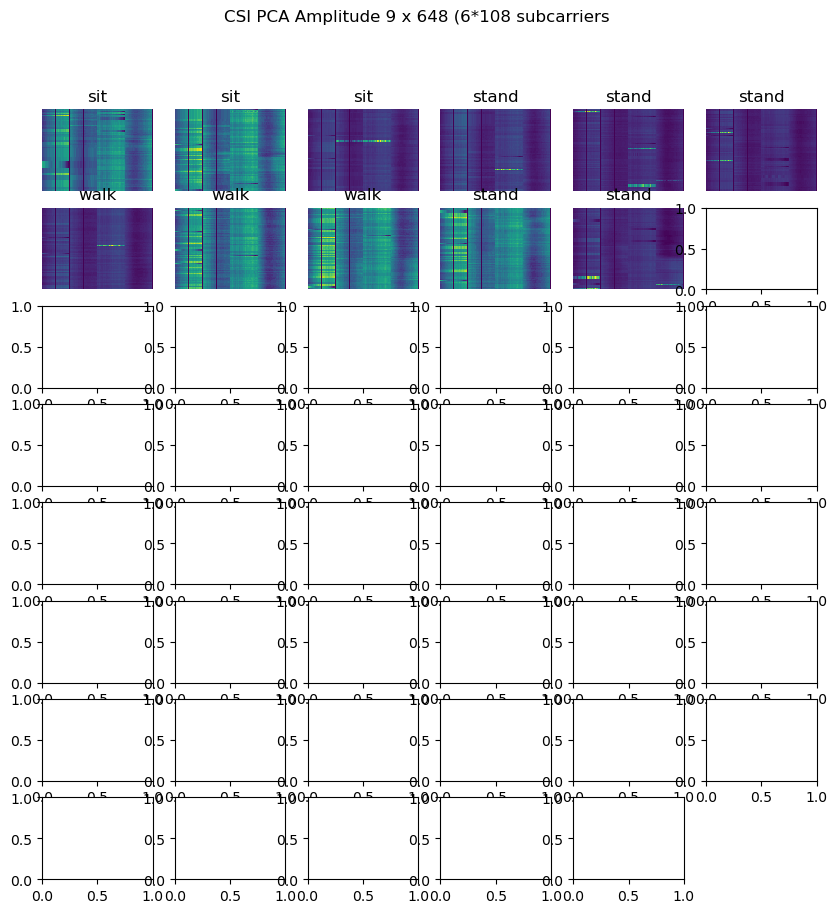

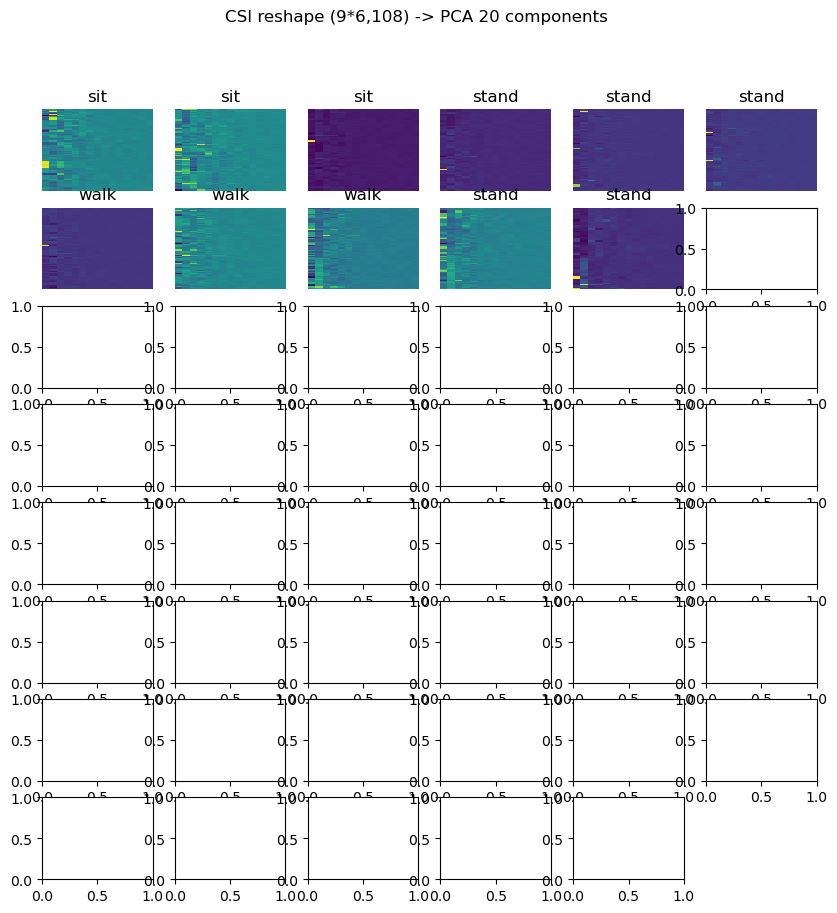

In [69]:
import matplotlib.pyplot as plt
import itertools
import csv
import os
import pandas
import numpy as np
import math
import cmath
from PIL import Image
import glob

from sklearn.decomposition import PCA
    
pca = PCA(n_components = 15)


x = []
y = []
yv= []
ya= []
carrier = []
trainy=[]
trainx=[]

with open(file_in,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        x.append(float(row[13]))
        y.append(row[16])

#yb=[float(item) for item in y[0][1:-1].split(',')]     # remov '[' and ']'          
print(len(y),len(y[0]))

fig, axs = plt.subplots(8,6)
fig.suptitle('CSI PCA Amplitude 9 x 648 (6*108 subcarriers')
plt.axis('off')
fig.set_figwidth(10)
fig.set_figheight(10)

fg, ax = plt.subplots(8,6)
fg.suptitle('CSI reshape (9*6,108) -> PCA 20 components')
plt.axis('off')
fg.set_figwidth(10)
fg.set_figheight(10)

print(round(len(t)%N10s/NS/2))
    
for k in range (44):            # Total 10 seconds frames
    CSi = []
    CSr = []
    for j in range (N10s*k,N10s*(k+1),NS):         # One 10 seconds Frame
        cvv=[]
        for i in range(NS):            # shoul be 6 (sensor 11 is not delivering
            cvv.append([float(item) for item in y[i+j][1:-1].split(',')])

        cv=np.array(cvv)
        cv=cv.flatten()            # 1080 CSI values => 1 line of CSI image

        ci=cv[0:len(cv):2]         # Frame Size = [N10s/Ns,(216/2 Im,Re || Amp,Pha)*NS]
        cr=cv[1:len(cv):2]

        CSi.append(ci)
        CSr.append(cr)

    imgI = np.array(CSi)
    imgR = np.array(CSr)

    aa=np.array(imgI)
    ap=np.array(imgR)
    li,co = imgI.shape

    for i in range(li):
        for c in range(co):
            # print("i,c",i,c)
            aa[i][c]=round(abs(complex(imgI[i,c],imgR[i,c])))
            ap[i][c]=round(cmath.phase(complex(imgI[i,c],imgR[i,c])))
 
#    print("shape cv",cv.shape,"shape imgI",imgI.shape)
   
#    k - corresponds to (50, 33, 10) cycles for NS = (1,2,6)
#    
#    sit    stand   walk   stand    sit    stand   walk  stand  sit
# k: 0      3       6      9        12     15      18    21     24   27   
         
    if k in range(0,2) or k in range (12,14) or k in range (24,27): ttxt='sit'
    if k in range(3,5) or k in range (9,11) or k in range (15,17) or k in range (21,23): ttxt='stand'
    if k in range(6,8) or k in range (18,20): ttxt='walk'
   
    
    axs[k//6,k%6].imshow(aa, interpolation='nearest',aspect='auto')   
    axs[k//6,k%6].axis('off')
    axs[k//6,k%6].title.set_text(ttxt)
    
    ab=np.reshape(aa, (co,li))
    aaPCA = pca.fit_transform(aa)
    ax[k//6,k%6].imshow(aaPCA, interpolation='nearest',aspect='auto')   
    ax[k//6,k%6].axis('off')
    ax[k//6,k%6].title.set_text(ttxt)
    
    trainy.append(ttxt)
    trainx.append(aaPCA)
    
print('len(y),len(y[0])',len(y),len(y[0]),'NS',NS,'N10s',N10s)
print('imgI',imgI.shape,'aaPCA',aaPCA.shape)
print('aa',aa.shape)
# 1207601     

#print("t(min):",277558.933/1000/60, "Lines per frame:",4201/N10s/NS)

print(trainy)
print(len(trainx),len(trainx[0]),len(trainx[0][0]))


img [,241,,151,,241,,151,,151,,171,,161,,081,,,,,,,,071,,, real 41,,161,,241,,151,,051,,061,,161,,151,,079798981,,0997
img [52-,,52-,,72-,,72-,,82-,,92-03-02-03-12-13-14-13-14-2 real -,,52-,,72-,,72-,,72-,,82-,,1,,1,,1,,1,,1,,1,,1,,1,,1,
img [181,,271,,281,,171,,171,,371,,371,,271,,341,,241,,361 real 1,,181,,291,,181,,171,,161,,361,,261,,461,,241,,251,,4
img [,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,059597961,,1 real 232333352535353536364747474748585858685941,,,,,,,,171,
1789 587


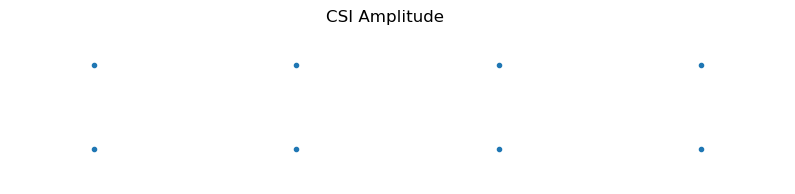

In [70]:
import matplotlib.pyplot as plt
import itertools
import csv
import os
import pandas
import numpy as np
import math
import cmath
from PIL import Image
import glob

from sklearn.decomposition import PCA
    
pca = PCA(n_components = 15)


x = []
y = []
yv= []
ya= []
carrier = []
trainy=[]
trainx=[]

with open(file_in,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        x.append(float(row[13]))
        y.append(row[16])

#yv=np.array(y)   
#print(yv.shape)
#for k in range(4):
#    print(yv[0:20])
            
        
fig, axs = plt.subplots(2,4)
fig.suptitle('CSI Amplitude')
plt.axis('off')
fig.set_figwidth(10)
fig.set_figheight(2)  

for k in range(1,5):
#    ya=np.array(y[k])
    imgp=y[k][0:108:2]
    realp=y[k][1:108:2]
    axs[0,k-1].plot( imgp,  linestyle = 'dashed', marker = '.',label = "abs(CSI)") 
    axs[0,k-1].axis('off')
    axs[1,k-1].plot( realp, linestyle = 'dashed', marker = '.',label = "phase(CSI)") 
    axs[1,k-1].axis('off')
    #axs[k//2,k%2].axis('off')
    print('img',imgp,'real',realp)


#yb=[float(item) for item in y[0][1:-1].split(',')]     # remov '[' and ']'          
print(len(y),len(y[0]))




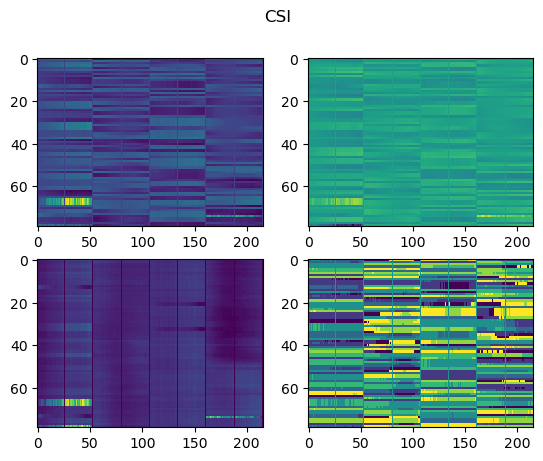

In [71]:
fig, axs = plt.subplots(2,2)
fig.suptitle('CSI')
axs[0,0].imshow(imgI, interpolation='nearest',aspect='auto')
axs[0,1].imshow(imgR, interpolation='nearest',aspect='auto')

axs[1,0].imshow(aa, interpolation='nearest',aspect='auto')
axs[1,1].imshow(ap, interpolation='nearest',aspect='auto')




TypeError: gca() got an unexpected keyword argument 'projection'

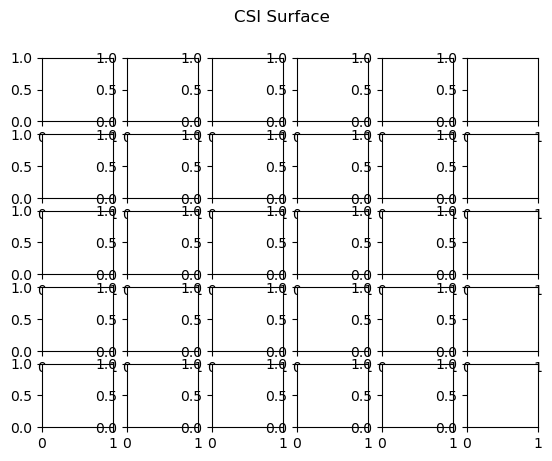

<Figure size 640x480 with 0 Axes>

In [72]:
from mpl_toolkits.mplot3d import axes3d
import scipy.misc
import matplotlib.pyplot as plt
import itertools
import csv
import os
import pandas
import numpy as np
import math
import cmath
from PIL import Image
import glob
from sklearn.decomposition import PCA
    
pca = PCA(n_components = 10)

fig, axs = plt.subplots(5,6)
fig.suptitle('CSI Surface')

x = []
y = []
yv= []
ya= []

with open(file_in,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        x.append(float(row[13]))
        y.append(row[16])
    
for k in range (26):            # Total 10 seconds frames
    CSi = []
    CSr = []
    for j in range (N10s*k,N10s*(k+1),NS):         # One 10 seconds Frame
        cvv=[]
        for i in range(NS):            # shoul be 6 (sensor 11 is not delivering
            cvv.append([float(item) for item in y[i+j][1:-1].split(',')])

        cv=np.array(cvv)
        cv=cv.flatten()            # 1080 CSI values => 1 line of CSI image

        ci=cv[0:len(cv):2]         # Frame Size = [N10s/Ns,(216/2 Im,Re || Amp,Pha)*NS]
        cr=cv[1:len(cv):2]

        CSi.append(ci)
        CSr.append(cr)

    imgI = np.array(CSi)
    imgR = np.array(CSr)

    aa=np.array(imgI)
    ap=np.array(imgR)
    li,co = imgI.shape

    for i in range(li):
        for c in range(co):
            # print("i,c",i,c)
            aa[i][c]=round(abs(complex(imgI[i,c],imgR[i,c])))
            ap[i][c]=round(cmath.phase(complex(imgI[i,c],imgR[i,c])))
 
#    print("shape cv",cv.shape,"shape imgI",imgI.shape)
   
#    k - corresponds to (50, 33, 10) cycles for NS = (1,2,6)
#    
#    sit    stand   walk   stand    sit    stand   walk  stand  sit
# k: 0      3       6      9        12     15      18    21     24   27   
         
    if k in range(0,2) or k in range (12,14) or k in range (24,27): ttxt='sit'
    if k in range(3,5) or k in range (9,11) or k in range (15,17) or k in range (21,23): ttxt='stand'
    if k in range(6,8) or k in range (18,20): ttxt='walk'
   
    
    ab=np.reshape(aa, (co,li))
    aaPCA = pca.fit_transform(aa)
    
    #print(aa.shape,aaPCA.shape)
    
    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:aa.shape[0], 0:aa.shape[1]]

    # create the figure
    fig = plt.figure()
    axs[k//6,k%6] = fig.gca(projection='3d')
    axs[k//6,k%6].plot_surface(xx, yy, aa ,rstride=1, cstride=1, cmap=plt.cm.hot,
            linewidth=0)

    # show it
plt.show()

In [73]:
from mpl_toolkits.mplot3d import axes3d

import scipy.misc
# downscaling has a "smoothing" effect
#aa = scipy.misc.imresize(aa, 0.15, interp='cubic')

print(aa.shape[0],aa.shape[1])
                              
#aa=np.array(aa)
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:aa.shape[0], 0:aa.shape[1]]

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, aa ,rstride=1, cstride=1, cmap=plt.cm.hot,
        linewidth=0)

# show it
plt.show()

79 216


TypeError: gca() got an unexpected keyword argument 'projection'

<Figure size 640x480 with 0 Axes>

411
17064


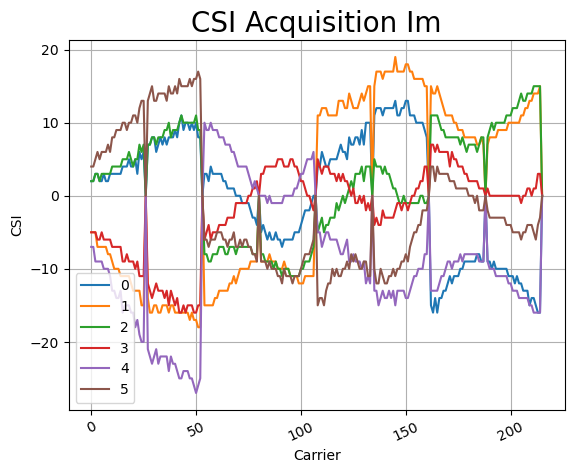

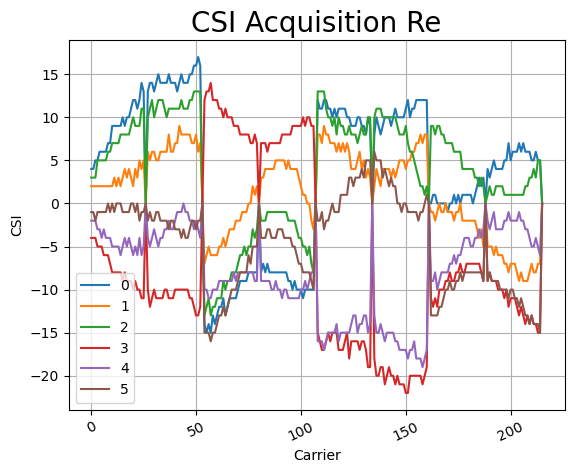

IndexError: index 411 is out of bounds for axis 0 with size 411

In [74]:
#cv = cv[0:216]    # remove 'end of frame' from data[]
cv = cv[cv != 0]  # remove '0' -> guard subcarriers


cv=cv[:-1]
print(cv.size)

#plt.plot( cv[0::2], color = 'g', linestyle = 'dashed', marker = '.',label = "Im")
#plt.plot( cv[1::2], color = 'r', linestyle = 'dashed', marker = '.',label = "Re")  
print(imgI.size)

plt.plot( imgI[0:6].transpose(),label=['0','1','2','3','4','5'])

plt.xticks(rotation = 25)
plt.xlabel('Carrier')
plt.ylabel('CSI')
plt.title('CSI Acquisition Im', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

plt.plot( imgR[0:6].transpose(),label=['0','1','2','3','4','5'])  
plt.xticks(rotation = 25)
plt.xlabel('Carrier')
plt.ylabel('CSI')
plt.title('CSI Acquisition Re', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

aa=[]
ap=[]
for i in range(0,cv.size,2):
    aa.append(abs(complex(cv[i],cv[i+1])))
    ap.append(cmath.phase(complex(cv[i],cv[i+1])))

aaM=np.array(aa)
apM=np.array(ap)
print('aaM.shape',aaM.shape)


plt.plot( aaM, label = "abs(CSI)")
plt.xticks(rotation = 25)
plt.xlabel('Carrier')
plt.ylabel('CSI')
plt.title('CSI Acquisition Abs', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

plt.plot( apM, label = "phase(CSI)")
plt.xticks(rotation = 25)
plt.xlabel('Carrier')
plt.ylabel('CSI')
plt.title('CSI Acquisition Phase', fontsize = 20)
plt.grid()
plt.legend()
plt.show()